In [5]:
pip install ndjson

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import json
from tqdm.notebook import tqdm

def load_data(file_path, num_lines=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        if num_lines is None:
            lines = file.readlines()
            num_lines = len(lines)
            for line in tqdm(lines, desc="Loading data", unit=" lines"):
                data.append(json.loads(line))
        else:
            for _ in tqdm(range(num_lines), desc="Loading data", unit=" lines"):
                line = file.readline()
                if not line:
                    break
                data.append(json.loads(line))
  
    return pd.DataFrame(data)

In [14]:
labels_df=load_data("labels.ndjson")

feeds_df=load_data("feeds.ndjson",33836)


Loading data:   0%|          | 0/33836 [00:00<?, ? lines/s]

Loading data:   0%|          | 0/33836 [00:00<?, ? lines/s]

In [15]:
print(labels_df)
print(feeds_df)

      occupation     id  gender  fame  birthyear
0      performer  31448    male  star       1943
1       politics  25082    male  star       1961
2       politics  15880    male  star       1960
3        creator   8821  female  star       1971
4         sports  14515    male  star       1983
...          ...    ...     ...   ...        ...
33831    creator  42602    male  star       1963
33832     sports  25170  female  star       1968
33833     sports  43768  female  star       1971
33834   politics  30338    male  star       1957
33835  performer  37017    male  star       1975

[33836 rows x 5 columns]
                                                    text     id
0      [Back at it with @americanidol looking for...h...  22704
1      [The last presidential election turned on fewe...  46305
2      [Angels 😇 \n@RobbieWilliams\nhttps://t.co/A6rx...  30260
3      [Listen to “Shallow”, “Always Remember Us This...   4874
4      [So happy for my island! Vote for Madeira, for...  41392
..

In [16]:
labels_df.set_index('id', inplace=True)
labels_df.sort_index(inplace=True)

feeds_df.set_index('id', inplace=True)
feeds_df.sort_index(inplace=True)



# Filtering datasets

In [17]:

max_length = feeds_df['text'].apply(len).max()
min_length = feeds_df['text'].apply(len).min()

print("max length of 'text':", max_length)
print("min length of 'text':", min_length)

max length of 'text': 3000
min length of 'text': 1


### YOU CAN EXPERIMENT WITH THE AMOUNT OF TWEETS

In [18]:
#filter users that have at least 150 tweets and select first 150 tweets to work with
tweets_num=150
feeds_df= feeds_df[feeds_df['text'].apply(len) > tweets_num]
feeds_df['text'] = feeds_df['text'].apply(lambda x: x[:tweets_num])


In [19]:
#now we have rows with only 150 tweets in 'text' field
max_length = feeds_df['text'].apply(len).max()
min_length = feeds_df['text'].apply(len).min()

print("max length of 'text':", max_length)
print("min length of 'text':", min_length)

max length of 'text': 150
min length of 'text': 150


In [20]:
#merge dataframes by id to get a single dataframe
merged_df = pd.merge(labels_df, feeds_df, on='id', how='inner')


In [21]:
del feeds_df
del labels_df

In [22]:
merged_df['occupation'].value_counts()

occupation
sports          12475
performer        9571
creator          5280
politics         2754
science           785
manager           717
professional      509
religious          32
Name: count, dtype: int64

### due to the fact that the difference between some categories is large, we will choose only a few that have the most data


In [23]:
merged_df = merged_df.loc[~((merged_df['occupation'] == 'religious')
                            | (merged_df['occupation'] == 'science') 
                            | (merged_df['occupation'] == 'manager') 
                            | (merged_df['occupation'] == 'professional'))]
merged_df['occupation'].value_counts()


occupation
sports       12475
performer     9571
creator       5280
politics      2754
Name: count, dtype: int64

In [ ]:
#as we did with numbers of tweets, we will select the first 2754 rows of each occupation to have a balanced dataset
sampled_df = merged_df.groupby('occupation', group_keys=False).apply(lambda x: x.sample(2754)).reset_index(drop=True)

In [38]:
sampled_df

,occupation,gender,fame,birthyear,text
0,creator,male,star,1972,"[@jsnell Purdy, RT @petridishes: look at least..."
1,creator,female,star,1975,[@stephanielaing I'm exhausted. Watching @CNN ...
2,creator,male,star,1948,[When the mood strikes! #TadashiShoji #DarkLip...
3,creator,male,star,1961,[@A_D_Morgan Mate they have great spirit in th...
4,creator,male,star,1964,[Fed up of the bile that Twitter seems to be f...
...,...,...,...,...,...
11011,sports,male,star,1990,"[RT @frankginda05: Lord, THANK YOU and thank y..."
11012,sports,male,star,1992,"[@jonathonrogers Ask, RT @jameshindley23: That..."
11013,sports,male,star,1991,[RT @COPA90US: Semifinal showdowns are set 🔒\n...
11014,sports,female,star,1986,"[RT @TrackGuyUSA: Thank you, @trackjenny, for ..."


In [39]:
occupations=list(set(sampled_df['occupation']))

In [40]:
merged_df.shape

(30080, 5)

In [41]:
occupations

['performer', 'politics', 'creator', 'sports']

# Preprocessing

In [42]:
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import functools

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text)

import re

def remove_links_tags_emojis(text):
    # exclude 
    text = re.sub(r'http\S+', '', text)
    
    # exclude tags
    text = re.sub(r'rt @\w+:', '', text)
    text = re.sub(r'#+', '', text)

    # exclude emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" # emojis
                               u"\U0001F300-\U0001F5FF" # symbols and code points
                               u"\U0001F680-\U0001F6FF" # transport icons and symbols
                               u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                               u"\U00002500-\U00002BEF" # additional Chinese characters
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    return text



In [44]:
prep_text = []
for text_list in tqdm(sampled_df['text']):
    cleaned_texts = []
    for text in text_list:
        cleaned_text = remove_multiple_spaces(remove_numbers(remove_punctuation(remove_links_tags_emojis(text.lower()))))
        cleaned_texts.append(cleaned_text)
    prep_text.append(cleaned_texts)


  0%|          | 0/11016 [00:00<?, ?it/s]

In [46]:
sampled_df['text']=prep_text


In [47]:
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Initialize SnowballStemmer for English
stemmer = SnowballStemmer("english")

#Stemming is a text preprocessing technique used in natural language processing (NLP) to reduce words to their root or base form.


In [48]:

def preprocess_text(text):
    stemmed_tokens = [stemmer.stem(token) for token in text.split() if token.lower() not in english_stopwords]
    processed_text = " ".join(stemmed_tokens)
    
    return processed_text

stemmed_texts_list = []
for text_list in tqdm(sampled_df['text']):
    stemmed_text = []
    for text in text_list:
            processed_text = preprocess_text(text)
            stemmed_text.append(processed_text)
    stemmed_texts_list.append(stemmed_text)


sampled_df['text'] = stemmed_texts_list

  0%|          | 0/11016 [00:00<?, ?it/s]

In [19]:
sampled_df


,occupation,gender,fame,birthyear,text
0,creator,male,star,1966,[oh guess funniest trevor twitter mellamotrevo...
1,creator,male,star,1977,[pour deviantdiscorama de ce jeudi au rexclub ...
2,creator,male,star,2000,[read great sisario book doolittl tho much rec...
3,creator,male,star,1972,"[wrong titl great news cast grow, excit brilli..."
4,creator,female,superstar,1970,[thank everyon came support vrtmuseum launch d...
...,...,...,...,...,...
11011,sports,male,star,1991,[book million vote final winner america best l...
11012,sports,female,star,2000,[oh might break snow shovel scrape hail sidewa...
11013,sports,male,star,1987,"[creativ maxim live moment, came year ago trai..."
11014,sports,male,star,1989,"[msl ticket go sale friday morn start r match,..."


# MODEL SELECTION

In [49]:
#join all the tweets for each row into a single text
sampled_df['text'] = sampled_df['text'].apply(lambda lst: ' '.join(lst))

In [138]:
#shuffle the rows
sampled_df = sampled_df.sample(frac=1, random_state=32)

In [ ]:
sampled_df.to_csv('save.csv', index=False)
#save the processed dataset

In [139]:
#define our X and y for model training
X=sampled_df['text']
y=sampled_df['occupation']

In [141]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42) 



In [69]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np 

classifiers = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Complement Naive Bayes', ComplementNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
]

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', None)  
])

for name, classifier in classifiers:
    pipeline.set_params(clf=classifier) 
    scores = cross_val_score(pipeline, X, y, cv=5) 
    print(f"{name}: mean precision = {np.mean(scores)}, standard deviation = {np.std(scores)}")


Multinomial Naive Bayes: mean precision = 0.685821017866249, standard deviation = 0.01553548097210322
Complement Naive Bayes: mean precision = 0.7018881198959017, standard deviation = 0.009144893833819197
K-Nearest Neighbors: mean precision = 0.6456969666013924, standard deviation = 0.010081947670131918
Decision Tree: mean precision = 0.5761626819721993, standard deviation = 0.008739060784651316
Random Forest: mean precision = 0.7133263665369693, standard deviation = 0.010534568902344566
Logistic Regression: mean precision = 0.7549932734853397, standard deviation = 0.013140722538521674


In [142]:
ppl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('Logistic Regression', LogisticRegression()),
])

In [143]:
%%time
ppl.fit(X_train, y_train)

CPU times: total: 42.2 s
Wall time: 25.2 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('Logistic Regression', LogisticRegression())])

In [ ]:
import pickle

#save model
with open('model.pkl', 'wb') as file:
    pickle.dump(ppl, file)


# Testing the model

In [107]:
y_pred=ppl.predict(X_test)

In [108]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=set(y_pred)))

accuracy 0.746974697469747
              precision    recall  f1-score   support

   performer       0.63      0.54      0.58       912
      sports       0.67      0.74      0.70       932
     creator       0.86      0.87      0.86       899
    politics       0.83      0.85      0.84       893

    accuracy                           0.75      3636
   macro avg       0.75      0.75      0.75      3636
weighted avg       0.74      0.75      0.74      3636



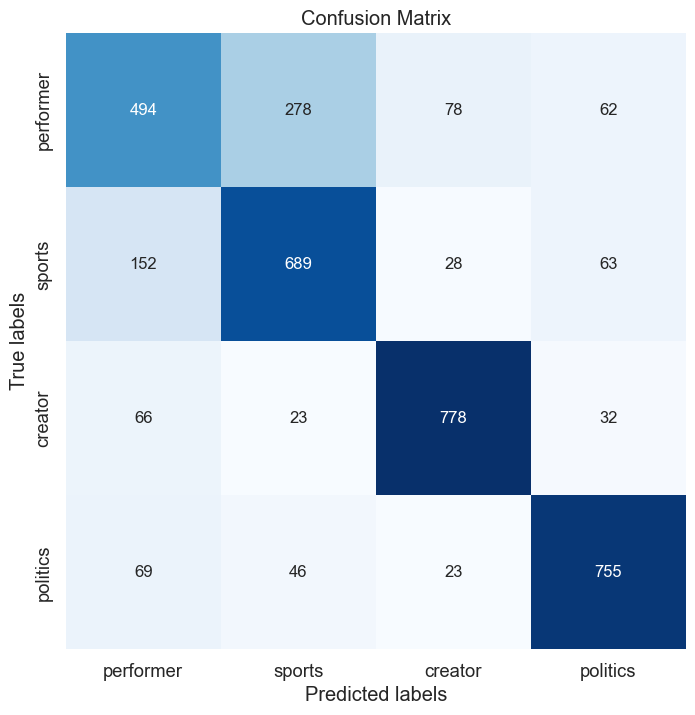

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred)

sns.set(font_scale=1.2)  

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 12}, cbar=False)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(set(y_true))) + 0.5, labels=set(y_true), ha='center')
plt.yticks(ticks=np.arange(len(set(y_true))) + 0.5, labels=set(y_true), va='center')

plt.show()


# HOW TO USE SAVED MODEL

In [145]:
import pickle

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [152]:
predictions = model.predict(X_test)


In [154]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(predictions, y_test))
print(classification_report(y_test, predictions, target_names=set(predictions)))

accuracy 0.7608264930653835
              precision    recall  f1-score   support

   performer       0.65      0.58      0.61       889
    politics       0.70      0.74      0.72       910
     creator       0.86      0.87      0.86       889
      sports       0.82      0.86      0.84       845

    accuracy                           0.76      3533
   macro avg       0.76      0.76      0.76      3533
weighted avg       0.76      0.76      0.76      3533

